In [46]:
import networks as n
from collections import OrderedDict
from collections import Counter
import math
import matplotlib.pyplot as plt
from adjustText import adjust_text

In [17]:
ds = n.load_feather()
projects_list = n.create_project_list(ds)
authors_list = n.create_authors_list(projects_list)

In [ ]:
def shannon_entropy(counts: Counter[str]) -> float:
    """Compute Shannon entropy from a Counter of region frequencies."""
    total = sum(counts.values())
    if total == 0:
        return 0.0
    entropy = 0.0
    for count in counts.values():
        p = count / total
        entropy -= p * math.log2(p)
    return entropy

def compute_entropy_per_author(authors: list[n.Author]) -> dict[str, float]:
    """Returns a mapping of author name to Shannon entropy based on canton distribution."""
    entropy_map = {}
    for author in authors:
        canton_counts = Counter(project.canton for project in author.projects)
        entropy = shannon_entropy(canton_counts)
        entropy_map[author.name_abr] = entropy
    return entropy_map

def get_year_and_maxcanton(author: n.Author):
    mean_year = 0
    year_count = 0
    for project in author.projects:
        if project.year < 2000:
            mean_year += project.year
            year_count += 1
    mean_year = (mean_year / year_count) if year_count else 2020

    cantons = {}
    for project in author.projects:
        cantons[project.canton] = cantons.get(project.canton, 0) + 1
    max_canton = max(cantons, key=cantons.get)

    return mean_year, max_canton

# Plotting function
def plot_entropy_vs_birth(authors: list[n.Author]):
    entropy_map = compute_entropy_per_author(authors)
    authors = [author for author in authors if len(author.projects) > 5]
    y = [entropy_map[author.name_abr] for author in authors]
    x = [get_year_and_maxcanton(author)[0] for author in authors]
    sizes = [max(30, len(author.projects) * 10) for author in authors]  # Scale bubble size
    colors = [get_year_and_maxcanton(author)[1] for author in authors]
    labels = [author.name_abr for author in authors]

    # Assign colors
    unique_regions = list(set(colors))
    region_colors = {region: f"C{idx}" for idx, region in enumerate(unique_regions)}
    color_values = [region_colors[region] for region in colors]

    plt.figure(figsize=(12, 7))
    scatter = plt.scatter(x, y, s=sizes, c=color_values, alpha=0.7, edgecolor='black')

    #Add labels near bubbles
    # for i, label in enumerate(labels):
    #     if len(authors[i].projects) > 16:
    #         plt.text(x[i] + 0.02, y[i], label, fontsize=9)
    
    # Use adjustText to place labels
    text_objects = [
        plt.text(x[i], y[i], labels[i], fontsize=9)
        for i in range(len(authors)) if len(authors[i].projects) > 13
    ]
    adjust_text(text_objects, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5), min_arrow_length=1)

    # Custom legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=region[:10],
                          markerfacecolor=color, markersize=10)
               for region, color in region_colors.items()]
    plt.legend(handles=handles, title="Region of Birth")

    plt.ylabel("Shannon Entropy (Regional Diversity)")
    plt.xlabel("Birth Year")
    plt.title("Architect Entropy: bubble size is number of projects by that architect")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

- laverrière, alphonse: né Carrouge (GE), mort Lausanne (VD)
- thévenaz, charles: Bullet et Lausanne (VD)
- epitaux, georges: Lausanne (VD)
- boschetti, fonso: né à Vezio (TI), Lausanne

- prince, ernest: Neuchâtel (NE)
morisod, paul: Sion (VS)

In [ ]:
authors_list = sorted(authors_list, key=lambda author: len(author.projects), reverse=True)
for author in authors_list:
    if len(author.projects) <= 10:
        continue
    cantons = {}
    for project in author.projects:
        cantons[project.canton] = cantons.get(project.canton, 0) + 1
    cantons = OrderedDict(sorted(cantons.items(), key=lambda item: item[1], reverse=True))
    max_canton = next(iter(cantons.items()))
    print(f"{author.name_abr}: {max_canton[0]}: {max_canton[1]}/{len(author.projects)} or {round((max_canton[1]/len(author.projects))*100, 2)}%")

laverrière, alphonse: VD: 34/45 or 75.56%
thévenaz, charles: VD: 27/41 or 65.85%
epitaux, georges: VD: 32/40 or 80.0%
boschetti, fonso: VD: 21/29 or 72.41%
béguin, jean: NE: 14/29 or 48.28%
prince, ernest: NE: 16/26 or 61.54%
morisod, paul: VS: 20/23 or 86.96%
piccard, marc: VD: 16/23 or 69.57%
monod, eugène: VD: 15/22 or 68.18%
schorp, alphonse: VD: 21/22 or 95.45%
brugger, frédéric: VD: 17/22 or 77.27%
convert, robert: NE: 12/21 or 57.14%
mamin, eugène: VD: 18/21 or 85.71%
luscher, rodolphe: VD: 18/21 or 85.71%
meyer, henri: VD: 14/20 or 70.0%
brugger, charles: VD: 18/20 or 90.0%
furrer, edouard: VS: 17/20 or 85.0%
lonchamp, jacques: VD: 14/19 or 73.68%
braillard, maurice: GE: 6/19 or 31.58%
regamey, jaques: VD: 14/17 or 82.35%
hoechel, arnold: GE: 12/17 or 70.59%
brera, georges: GE: 12/16 or 75.0%
perrelet, jean: VD: 8/16 or 50.0%
froidevaux, rené: VD: 10/15 or 66.67%
torcapel, john: GE: 12/15 or 80.0%
lozeron, arthur: GE: 10/15 or 66.67%
kyburz, jean: VS: 6/15 or 40.0%
schaffner, h

In [22]:
entropies = compute_entropy_per_author(authors_list)
for name, entropy in entropies.items():
    print(f"Author {name}: Entropy = {entropy:.3f}")

Author laverrière, alphonse: Entropy = 1.259
Author thévenaz, charles: Entropy = 1.683
Author epitaux, georges: Entropy = 1.153
Author boschetti, fonso: Entropy = 1.333
Author béguin, jean: Entropy = 2.028
Author prince, ernest: Entropy = 1.748
Author morisod, paul: Entropy = 0.678
Author piccard, marc: Entropy = 1.534
Author monod, eugène: Entropy = 1.580
Author schorp, alphonse: Entropy = 0.267
Author brugger, frédéric: Entropy = 1.301
Author convert, robert: Entropy = 1.791
Author mamin, eugène: Entropy = 0.818
Author luscher, rodolphe: Entropy = 0.818
Author meyer, henri: Entropy = 1.457
Author brugger, charles: Entropy = 0.569
Author furrer, edouard: Entropy = 0.748
Author lonchamp, jacques: Entropy = 1.337
Author braillard, maurice: Entropy = 2.294
Author regamey, jaques: Entropy = 0.834
Author hoechel, arnold: Entropy = 1.322
Author brera, georges: Entropy = 1.311
Author perrelet, jean: Entropy = 2.078
Author froidevaux, rené: Entropy = 1.692
Author torcapel, john: Entropy = 1.0

/tmp/ipykernel_28111/800097211.py:77: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/jeremie/Documents/Studium/EPFL_master/semester project/conpapers_apitest/env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


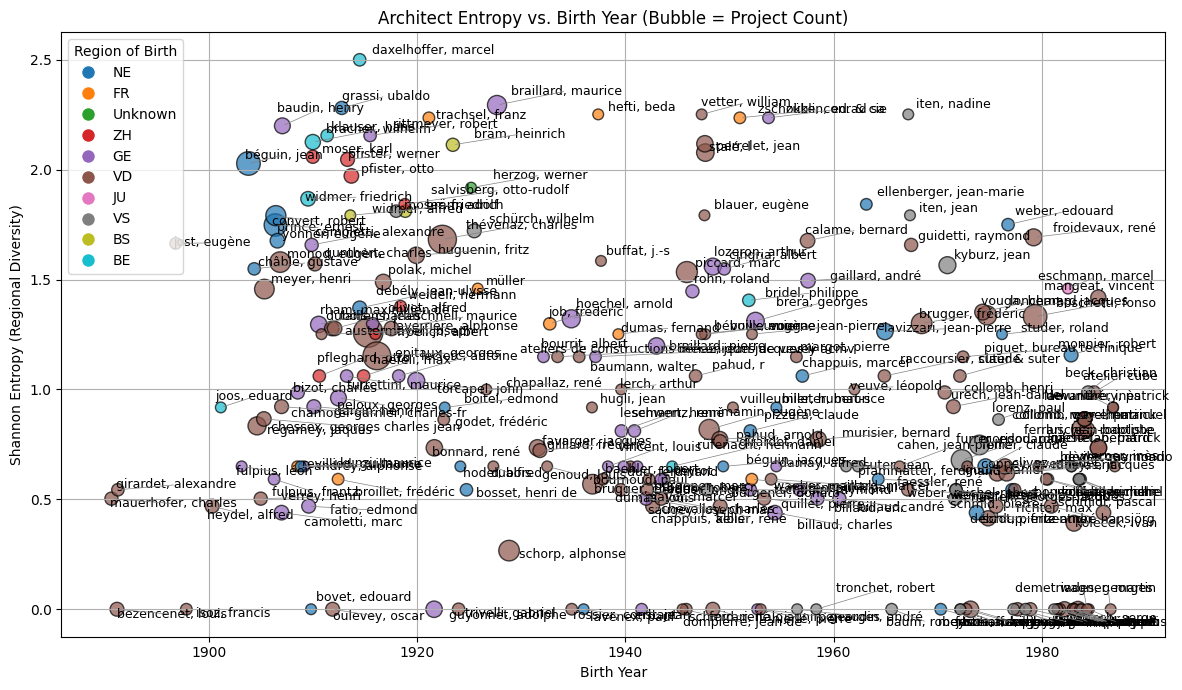

In [74]:
plot_entropy_vs_birth(authors_list)